## Multi-classification problem


In [75]:
# Uncomment the next line to install packages
!pip install torch torchvision matplotlib pandas seaborn requests scikit-optimize

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [77]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [78]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=False)

In [79]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [80]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [81]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


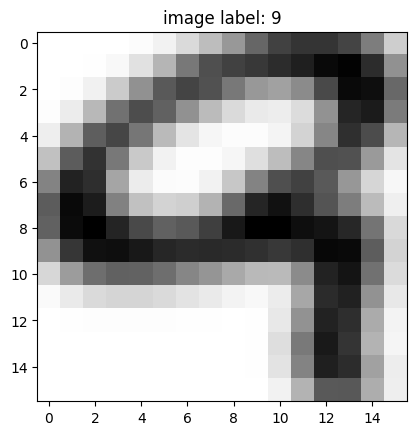

In [82]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

In [83]:
torch.manual_seed(0)

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [84]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


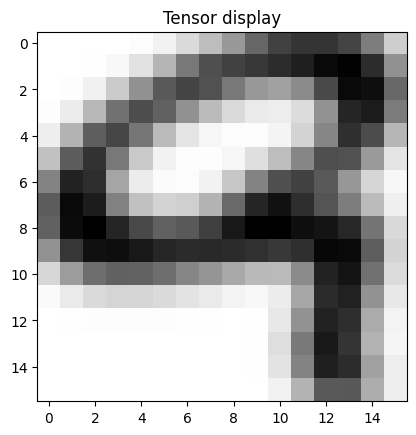

In [85]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [86]:
# split the dataset to training and validation sets
generator1 = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [6000, 1291], generator = generator1)

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [87]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)

        # Linear layer
        self.l1 = nn.Linear(256*16*16, 512)
        self.l2 = nn.Linear(512, 10)

    def forward(self, inputs): # Called when we apply the network
        h = F.relu(self.conv1(inputs))
        h2 = F.relu(self.conv2(h))
        h2 = F.relu(self.conv3(h2))
        h3 = self.l1(h2.view(h2.size(0), -1))
        outputs = F.softmax(self.l2(h3), dim=1)
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [88]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (l1): Linear(in_features=65536, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[-6.6414e-05, -2.3419e-03, -2.6149e-03,  ...,  1.1281e-03,
          1.0095e-03,  1.5560e-03],
        [ 9.0152e-04, -3.1859e-03,  2.2499e-03,  ...,  2.1501e-03,
          2.3621e-03,  1.8391e-03],
        [ 3.5748e-03, -3.3400e-03, -1.9439e-03,  ...,  3.1540e-03,
         -2.8710e-03, -3.8165e-03],
        ...,
        [-1.7898e-03,  3.0629e-03, -1.3874e-03,  ...,  3.6842e-03,
          1.5602e-04, -3.6098e-03],
        [ 2.8205e-03,  1.4102e-03,  4.1921e-04,  

In [89]:
# Shape of the Linear Layer
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([512, 65536])  b :  torch.Size([512])


## Train your Model

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [91]:
model1 = Model().to(device)

### Parameters
num_epochs = 30
batch_size = 64
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [92]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, train_dataset, val_dataset, CEL=False):
    train_error = []
    val_error = []
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=True, drop_last = True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            images, labels = images.to(device), labels.to(device)
            #y_pre = model(images.view(batch_size, -1)) #-> to train MLP
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape]
            y_pre = model(images) # to feed convolution layers

            if CEL == True:
                loss = criterion(y_pre, labels)
            else:
                # One-hot encoding or labels so as to calculate MSE error (not necessary if CrossEntropyLoss is used)
                labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
                labels_one_hot.zero_()
                labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
                loss = criterion(y_pre, labels_one_hot) #Real number

            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights
            epoch_average_loss += loss.item() * batch_size / len(train_dataset)
        train_error.append(epoch_average_loss)

        model.eval()
        with torch.no_grad():
            val_loader = DataLoader(val_dataset, batch_size, shuffle=True, drop_last = True)
            epoch_average_val_loss = 0.0
            for (images, labels) in val_loader:
                images, labels = images.to(device), labels.to(device)
                y_pre = model(images) # to feed convolution layers

                if CEL == True:
                    val_loss = criterion(y_pre, labels)
                else:
                    # One-hot encoding or labels so as to calculate MSE error (not necessary if cross entropy is used)
                    labels_one_hot = torch.FloatTensor(batch_size, 10).to(device)
                    labels_one_hot.zero_()
                    labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
                    labels_one_hot.to(device)
                    val_loss = criterion(y_pre, labels_one_hot) #Real number

                epoch_average_val_loss += val_loss.item() * batch_size / len(val_dataset)
            val_error.append(epoch_average_val_loss)
            #print('Epoch [{}/{}], train loss: {:.4f} and val loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss, epoch_average_val_loss))
    print('final train loss: {:.4f} and final validation loss: {:.4f}'.format(epoch_average_loss, epoch_average_val_loss))
    return train_error, val_error

In [93]:
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model1, train_set, val_set)

final train loss: 0.0071 and final validation loss: 0.0073


Text(0.5, 1.0, 'Visualization of training')

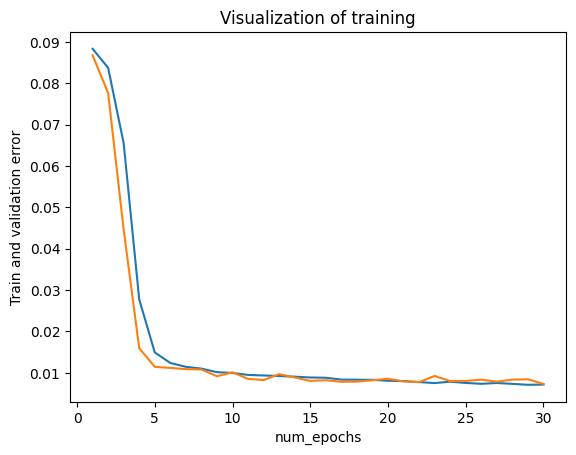

In [94]:
# plot the training error wrt. the number of epochs:
plt.plot(range(1, num_epochs+1), train_error, label = 'train loss')
plt.plot(range(1, num_epochs+1), val_error, label = 'val loss')
plt.xlabel("num_epochs")
plt.ylabel("Train and validation error")
plt.title("Visualization of training")

### Evaluate the Model on validation set

In [95]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            #images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum()
    #print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))
    return correct.item()/ len(dataset)

In [96]:
accuracy(val_set, model1)

0.9535243996901627

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

final train loss: 0.0061 and final validation loss: 0.0070


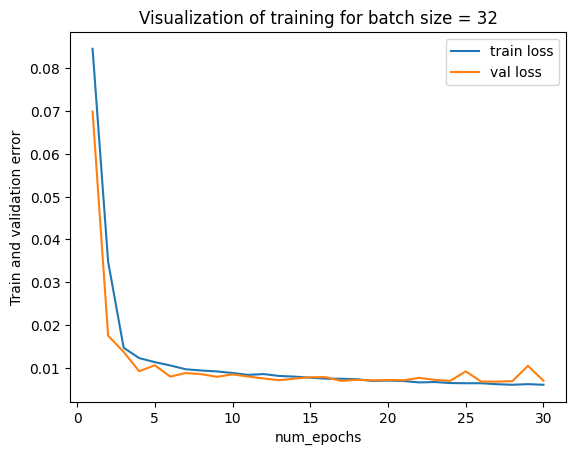

final train loss: 0.0070 and final validation loss: 0.0077


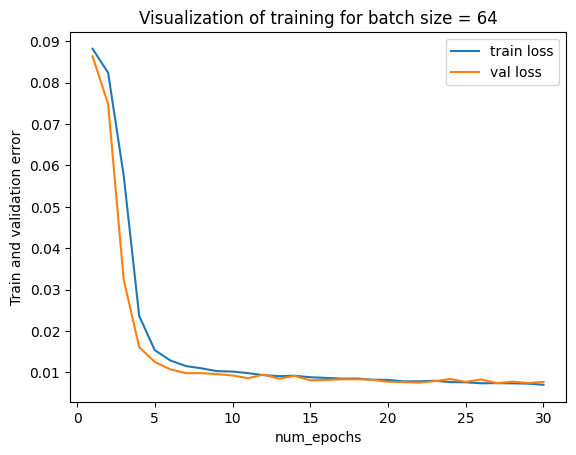

final train loss: 0.0084 and final validation loss: 0.0075


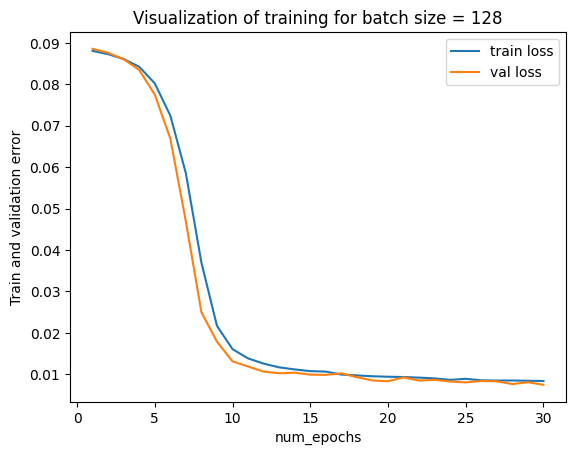

final train loss: 0.0093 and final validation loss: 0.0088


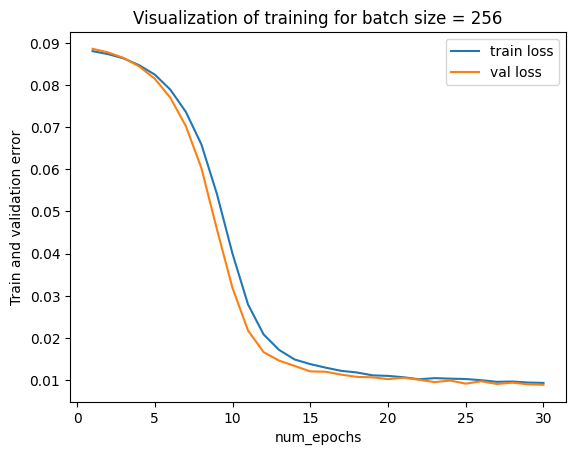

final train loss: 0.0168 and final validation loss: 0.0123


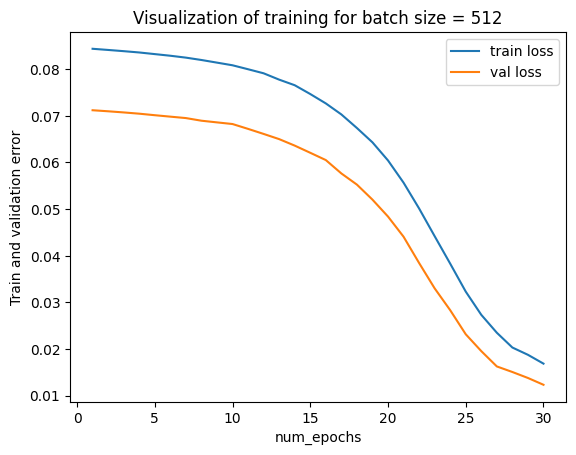

In [97]:
for batch_size in [32, 64, 128, 256, 512]:
        model = Model().to(device)

        ### Parameters ######
        num_epochs = 30
        criterion = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        #####################

        train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set)
        plt.plot(range(1, num_epochs+1), train_error, label = 'train loss')
        plt.plot(range(1, num_epochs+1), val_error, label = 'val loss')
        plt.xlabel("num_epochs")
        plt.ylabel("Train and validation error")
        plt.legend(loc = "upper right")
        plt.title(f"Visualization of training for batch size = {batch_size}")
        plt.show()

final train loss: 0.0888 and final validation loss: 0.0887


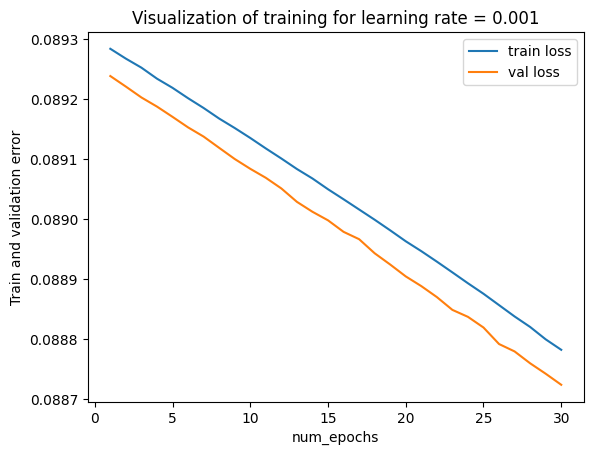

final train loss: 0.0331 and final validation loss: 0.0289


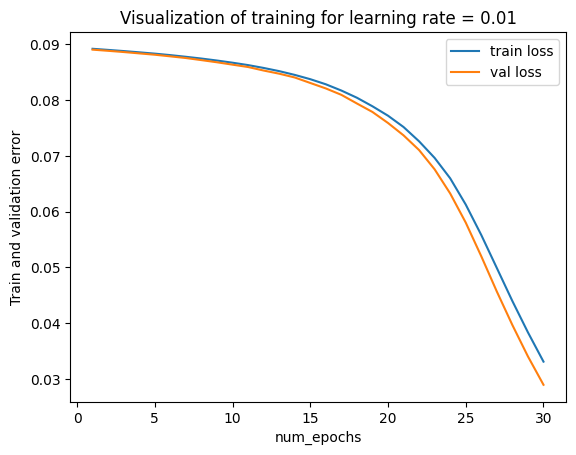

final train loss: 0.0073 and final validation loss: 0.0076


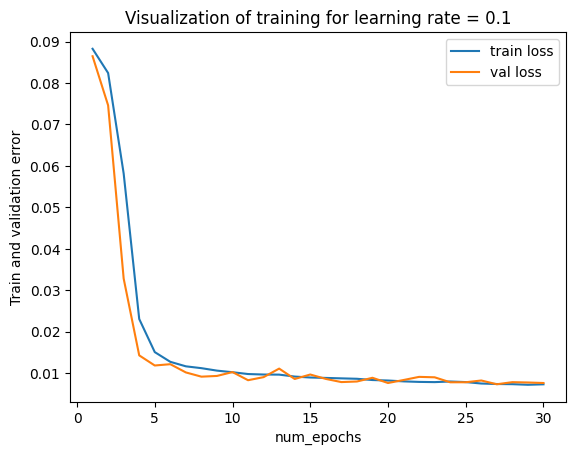

final train loss: 0.0006 and final validation loss: 0.0037


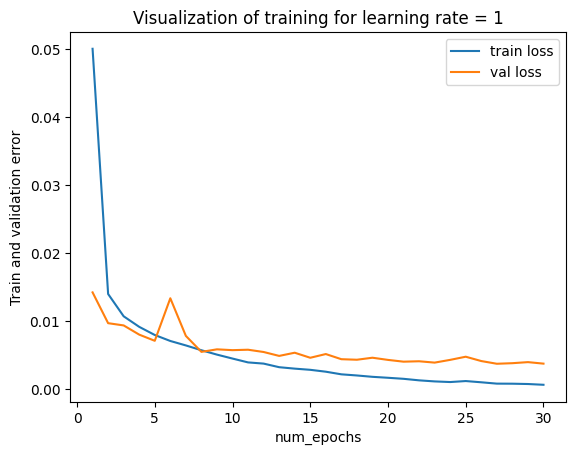

In [98]:
for lr in [0.001, 0.01, 0.1, 1]:
    model = Model().to(device)

    ### Parameters ######
    num_epochs = 30
    criterion = nn.MSELoss()
    batch_size = 64
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    #####################

    train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, val_set)
    plt.plot(range(1, num_epochs+1), train_error, label = 'train loss')
    plt.plot(range(1, num_epochs+1), val_error, label = 'val loss')
    plt.xlabel("num_epochs")
    plt.ylabel("Train and validation error")
    plt.legend(loc = "upper right")
    plt.title(f"Visualization of training for learning rate = {lr}")
    plt.show()

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

In [99]:
class Model_CEL(nn.Module):
    def __init__(self):
        super(Model_CEL, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)

        # Linear layer
        self.l1 = nn.Linear(256*4*4, 256)
        self.l2 = nn.Linear(256, 10)

    def forward(self, inputs): # Called when we apply the network
        h = F.relu(self.conv1(inputs))
        h = F.max_pool2d(h, kernel_size = 2)
        h2 = F.relu(self.conv2(h))
        h2 = F.max_pool2d(h2, kernel_size = 2)
        h2 = self.conv3(h2)
        h3 = self.l1(h2.view(h2.size(0), -1))
        outputs = self.l2(h3)
        return outputs

In [100]:
model_CEL = Model_CEL().to(device)

### Parameters
num_epochs = 100
batch_size = 256
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CEL.parameters(), lr=0.0001)
# I run the previous cell to adjust the number of epochs, the batch size and the learning rate to ensure they are still the best one with the cross entropy loss and Adam as an optimizer

final train loss: 0.0031 and final validation loss: 0.0668


Text(0.5, 1.0, 'Visualization of training')

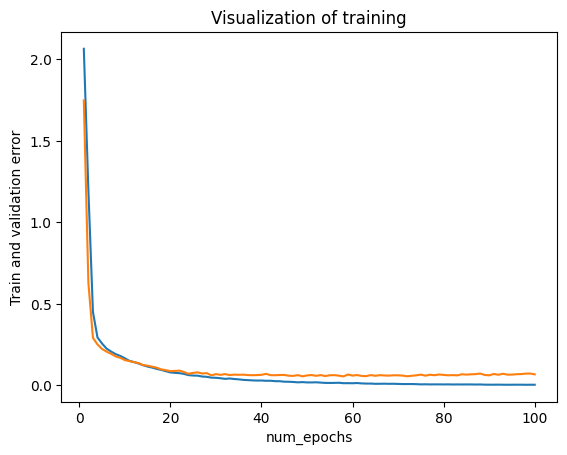

In [101]:
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, model_CEL, train_set, val_set, CEL=True)
# plot the training error wrt. the number of epochs:
plt.plot(range(1, num_epochs+1), train_error, label = 'train loss')
plt.plot(range(1, num_epochs+1), val_error, label = 'val loss')
plt.xlabel("num_epochs")
plt.ylabel("Train and validation error")
plt.title("Visualization of training")

In [102]:
accuracy(val_set, model_CEL)

0.9829589465530596

In [103]:
from skopt import gp_minimize, space
from skopt.utils import use_named_args

In [104]:
dimensions = [space.Real(10**-5, 0.1, prior = 'log-uniform', name='learning_rate'),
              space.Integer(16, 512, name='batch_size'),
              space.Integer(5, 100, name='nb_epoch')
              ]
parameters_default_values = [0.0001, 256, 100]

In [105]:
from tqdm import tqdm

@use_named_args(dimensions=dimensions)
def fit_opt(learning_rate, batch_size, nb_epoch):
    batch_size = int(batch_size)
    generator1 = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(dataset, [6000, 1291], generator = generator1)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last = True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=True, drop_last = True)

    model = Model_CEL().to(device)

    lr = float(learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    # Indicates to the network we are in training mode
    for epoch in tqdm(range(num_epochs)):
        model.train()
        epoch_average_loss = 0.0
        for (images, labels) in (train_loader):
            images, labels = images.to(device), labels.to(device)
            #y_pre = model(images.view(batch_size, -1)) #-> to train MLP
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape]
            y_pre = model(images) # to feed convolution layers

            loss = criterion(y_pre, labels) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights
            epoch_average_loss += loss.item() * batch_size / len(train_dataset)
        train_error.append(epoch_average_loss)

        model.eval()
        with torch.no_grad():
            epoch_average_val_loss = 0.0
            for (images, labels) in val_loader:
                images, labels = images.to(device), labels.to(device)
                y_pre = model(images) # to feed convolution layers

                val_loss = criterion(y_pre, labels) #Real number
                epoch_average_val_loss += val_loss.item() * batch_size / len(val_dataset)
            val_error.append(epoch_average_val_loss)
            #print('Epoch [{}/{}], train loss: {:.4f} and val loss: {:.4f}'.format(epoch+1, num_epochs, epoch_average_loss, epoch_average_val_loss))
    print('final train loss: {:.4f} and final validation loss: {:.4f}'.format(epoch_average_loss, epoch_average_val_loss))
    score = 1- accuracy(val_dataset, model)
    print(score)
    return score

In [106]:
gp_result = gp_minimize(
    # ****START CODE****
    func = fit_opt,
    dimensions = dimensions,
    x0 = parameters_default_values,
    n_calls = 11
    # ****END CODE****
    )

print(f"Optimal set of parameters found at iteration {np.argmin(gp_result.func_vals)}")
print(gp_result.x)

100%|██████████| 100/100 [01:17<00:00,  1.30it/s]


final train loss: 0.0036 and final validation loss: 0.0624
0.017041053446940402


100%|██████████| 100/100 [01:18<00:00,  1.28it/s]


final train loss: 2.2631 and final validation loss: 1.9418
0.8350116189000775


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


final train loss: 2.2825 and final validation loss: 2.2012
0.8559256390395042


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


final train loss: 0.0001 and final validation loss: 0.1122
0.015491866769945739


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


final train loss: 0.0001 and final validation loss: 0.0763
0.017041053446940402


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


final train loss: 2.2460 and final validation loss: 2.0527
0.8350116189000775


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


final train loss: 0.0741 and final validation loss: 0.0846
0.021688613477924057


100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


final train loss: 0.0120 and final validation loss: 0.0560
0.016266460108443015


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


final train loss: 2.1973 and final validation loss: 1.9592
0.8350116189000775


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


final train loss: 2.2744 and final validation loss: 2.1970
0.8350116189000775


100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


final train loss: 0.0002 and final validation loss: 0.0806
0.014717273431448463
Optimal set of parameters found at iteration 10
[0.0002171457620043393, 212, 61]


In [112]:
final_model = Model_CEL().to(device)

# Optimal set of parameters found at iteration 10 with gp_minimize
# [0.0002171457620043393, 212, 61]

### Parameters
num_epochs = 61
batch_size = 212
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.00021)

final train loss: 0.0024 and final validation loss: 0.0593


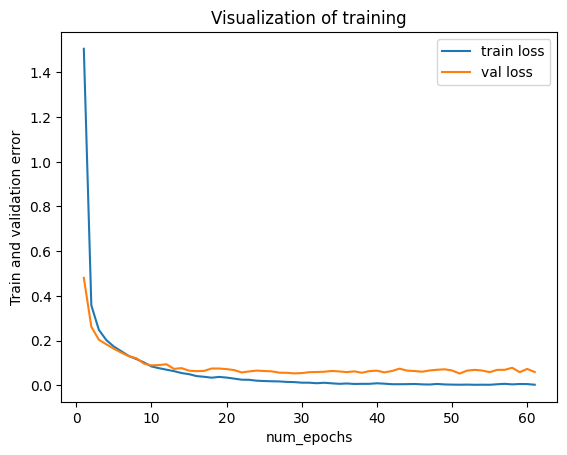

In [113]:
train_error, val_error = train(num_epochs, batch_size, criterion, optimizer, final_model, train_set, val_set, CEL=True)
plt.plot(range(1, num_epochs+1), train_error, label = 'train loss')
plt.plot(range(1, num_epochs+1), val_error, label = 'val loss')
plt.xlabel("num_epochs")
plt.ylabel("Train and validation error")
plt.legend(loc = "upper right")
plt.title(f"Visualization of training")
plt.show()

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [114]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

1831726

In [115]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [116]:
accuracy(test_set, final_model)

0.9606377678126558